In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.datasets import get_rdataset
from statsmodels.tsa.seasonal import seasonal_decompose
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load Data Sets

In [3]:
from statsmodels.datasets import co2, get_rdataset

# Mauna Loa Weekly Atmospheric CO2 Data
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()

#Monthly Airline Passenger Numbers 1949-1960, in thousands
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)

# load the file of stocks closing_price.csv to df from the folder 'Data_sets' located in the local project folder
closing_price = pd.read_csv('./Data_sets/closing_price.csv', index_col='Date', parse_dates=True)

btc_data = yf.download('BTC-USD', start='2010-01-01', end='2024-08-04')
# Extract the 'Close' price
btc_close = btc_data['Close']

[*********************100%***********************]  1 of 1 completed


In [4]:
# Load the Sunspot dataset
sunspot_data = get_rdataset("sunspot.year").data
# Set the index by the 'time' column
sunspot_data.set_index('time', inplace=True)
# set index to be a datetime type 
sunspot_data.index = pd.to_datetime(sunspot_data.index, format='%Y')


# Exponential Smothing


## Implementing Single Exponential Smoothing

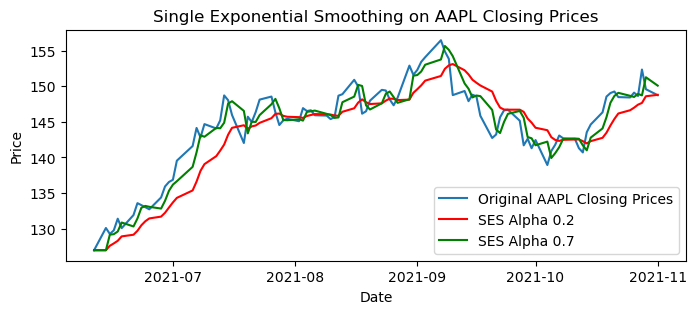

In [5]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# cut the last 100 days of the AAPL closing price
AAPL = closing_price['AAPL'][-100:]

# Apply Single Exponential Smoothing
alpha = 0.2  # Smoothing factor
model = SimpleExpSmoothing(AAPL).fit(smoothing_level=alpha, optimized=False)
AAPL_smoothed_02 = model.fittedvalues # Get the smoothed series

alpha = 0.7  # Smoothing factor
model = SimpleExpSmoothing(AAPL).fit(smoothing_level=alpha, optimized=False)
AAPL_smoothed_07 = model.fittedvalues # Get the smoothed series

# Plot the original and smoothed series
plt.figure(figsize=(8, 3))
plt.plot(AAPL, label='Original AAPL Closing Prices')
plt.plot(AAPL_smoothed_02, label='SES Alpha 0.2', color='red')
plt.plot(AAPL_smoothed_07, label='SES Alpha 0.7', color='green')
plt.title('Single Exponential Smoothing on AAPL Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## Forecasting with double and triple exponential smoothing


In [6]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [7]:
def split_data(df, test_prop= 0.1):
    """
    Splits the dataframe into train and test sets based on the specified test size
    Test size is the proportion of the dataset to include in the test split
    """
    test_size = int(test_prop * len(df))
    
    train, test = df[:-test_size], df[-test_size:]
    print('train shape:', train.shape)
    print('test shape:', test.shape)
    return train, test, test_size

### Exponential smoothing on the CO2 dataset with trend and seasonality addative model

train shape: (850, 1)
test shape: (150, 1)


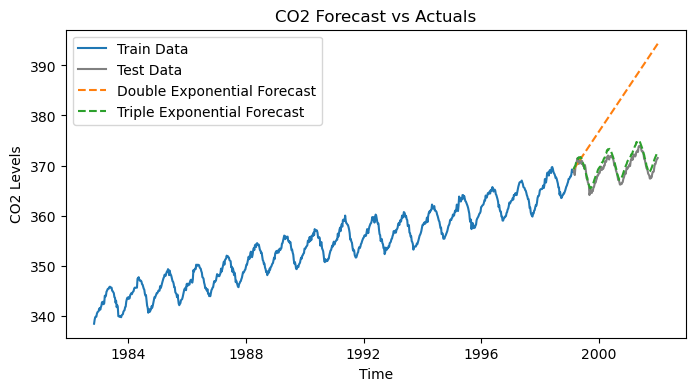

Level: 0.41
Trend: 0.00
Seasonal: 0.00
Double Exponential Smoothing RMSE: 14.10
Triple Exponential Smoothing RMSE: 1.11


In [8]:
# Use the last 1000 observations for the analysis
co2_df_short = co2_df[-1000:] # Use the last 1000 observations for the analysis

# Split the data into train and test sets
train, test, test_size = split_data(co2_df_short, test_prop=0.15)

# Double Exponential Smoothing
# Assuming an additive trend might be appropriate; adjust based on data analysis
model_double = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=False)
fit_double = model_double.fit()
forecast_double = fit_double.forecast(steps=test_size)

# Triple Exponential Smoothing (Holt-Winters)
# Assuming addative trend and seasonality of 52 weeks per year
model_triple = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=52)
fit_triple = model_triple.fit()
forecast_triple = fit_triple.forecast(steps=test_size)

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data', color='gray')
plt.plot(test.index, forecast_double, label='Double Exponential Forecast', linestyle='--')
plt.plot(test.index, forecast_triple, label='Triple Exponential Forecast', linestyle='--')
plt.title('CO2 Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('CO2 Levels')
plt.legend()
plt.show()

# Get the fitted level, trand and seasonal parameters
params = fit_triple.params['smoothing_level'], fit_triple.params['smoothing_trend'], fit_triple.params['smoothing_seasonal']
# print the parameters
print(f'Level: {params[0]:.2f}')
print(f'Trend: {params[1]:.2f}')
print(f'Seasonal: {params[2]:.2f}')

# Calculate and print RMSE
rmse_double = np.sqrt(mean_squared_error(test, forecast_double))
rmse_triple = np.sqrt(mean_squared_error(test, forecast_triple))
print(f'Double Exponential Smoothing RMSE: {rmse_double:.2f}')
print(f'Triple Exponential Smoothing RMSE: {rmse_triple:.2f}')

### Exponential smoothing on the air_passengers dataset with trend and seasonality multiplicative model

train shape: (101, 1)
test shape: (43, 1)


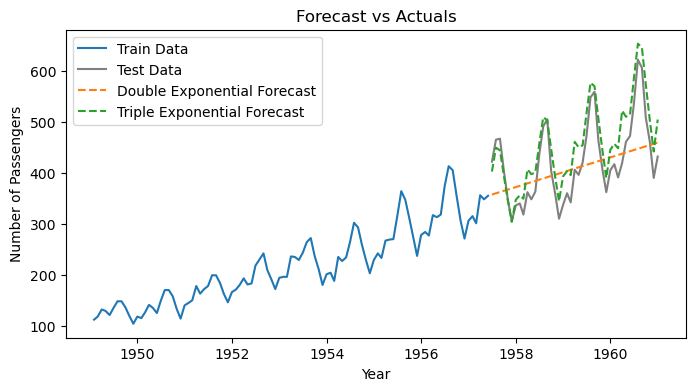

Level: 0.69
Trend: 0.00
Seasonal: 0.00
Double Exponential Smoothing RMSE: 69.40
Triple Exponential Smoothing RMSE: 41.87


In [9]:
# Splitting the data into train and test sets with last 40 months as test set
train, test, test_size = split_data(airp_df, test_prop=0.3)


# Double Exponential Smoothing
model_double = ExponentialSmoothing(train, trend='add', seasonal=None)
fit_double = model_double.fit()
forecast_double = fit_double.forecast(steps=test_size)

# Triple Exponential Smoothing (Holt-Winters)
model_triple = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=12)
fit_triple = model_triple.fit()
forecast_triple = fit_triple.forecast(steps=test_size)

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data', color='gray')
plt.plot(test.index, forecast_double, label='Double Exponential Forecast', linestyle='--')
plt.plot(test.index, forecast_triple, label='Triple Exponential Forecast', linestyle='--')
plt.title('Forecast vs Actuals')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# Get the fitted level, trand and seasonal parameters
params = fit_triple.params['smoothing_level'], fit_triple.params['smoothing_trend'], fit_triple.params['smoothing_seasonal']
# print the parameters
print(f'Level: {params[0]:.2f}')
print(f'Trend: {params[1]:.2f}')
print(f'Seasonal: {params[2]:.2f}')

# Calculate and print RMSE
rmse_double = np.sqrt(mean_squared_error(test, forecast_double))
rmse_triple = np.sqrt(mean_squared_error(test, forecast_triple))
print(f'Double Exponential Smoothing RMSE: {rmse_double:.2f}')
print(f'Triple Exponential Smoothing RMSE: {rmse_triple:.2f}')

### Explore exponential smothing method on a complex time series

train shape: (240,)
test shape: (60,)


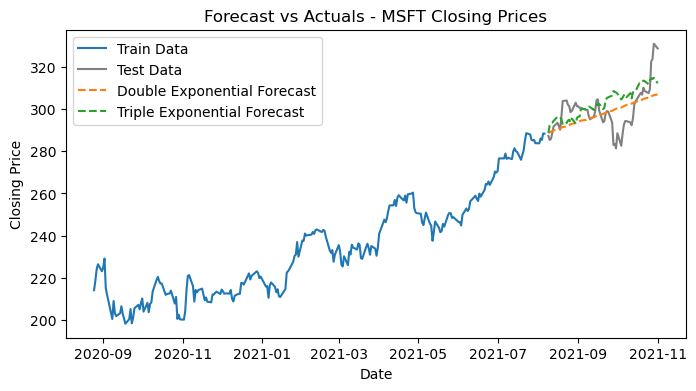

Double Exponential Smoothing RMSE: 8.97
Triple Exponential Smoothing RMSE: 10.16


In [51]:
#  cut the closing_price['MSFT'] for the last 200 days
MSFT = closing_price['MSFT'][-300:]

# Splitting the data
train, test, test_size = split_data(MSFT, test_prop=0.2)

# Double Exponential Smoothing
model_double = ExponentialSmoothing(train, trend='add', seasonal=None)
fit_double = model_double.fit()
forecast_double = fit_double.forecast(steps=test_size)

# Triple Exponential Smoothing (Holt-Winters)
model_triple = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=30)
fit_triple = model_triple.fit()
forecast_triple = fit_triple.forecast(steps=test_size)

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data', color='gray')
plt.plot(test.index, forecast_double, label='Double Exponential Forecast', linestyle='--')
plt.plot(test.index, forecast_triple, label='Triple Exponential Forecast', linestyle='--')
plt.title('Forecast vs Actuals - MSFT Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Calculate and print RMSE
rmse_double = np.sqrt(mean_squared_error(test, forecast_double))
rmse_triple = np.sqrt(mean_squared_error(test, forecast_triple))
print(f'Double Exponential Smoothing RMSE: {rmse_double:.2f}')
print(f'Triple Exponential Smoothing RMSE: {rmse_triple:.2f}')

# Autoregressive (AR) & Moving Average (MA) Model

## Explore Data & Check for Stationarity

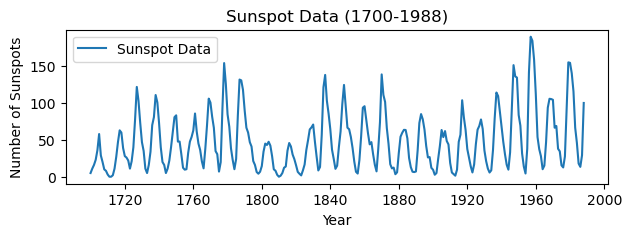

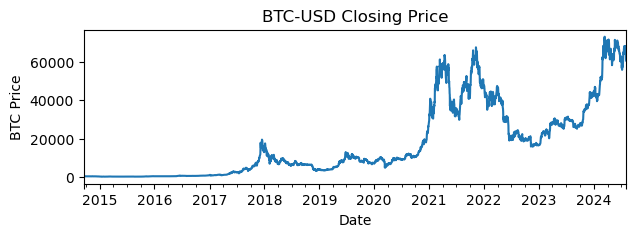

In [261]:
# Plot the Sunspot data
plt.figure(figsize=(7, 2))
plt.plot(sunspot_data.index, sunspot_data['value'], label='Sunspot Data')
plt.title('Sunspot Data (1700-1988)')
plt.xlabel('Year')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.show()

# plot the BTC closing price
btc_close.plot(title='BTC-USD Closing Price', figsize=(7, 2))
plt.title('BTC-USD Closing Price')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.show()


In [262]:

# Perform ADF test on the sunspot data
result = adfuller(sunspot_data['value'])
print(f'sunspot ADF Statistic: {result[0]}')
print(f'sunspot p-value: {result[1]}')

# Perform ADF test on the closing price of BTC
result = adfuller(btc_close)
print(f'BTC ADF Statistic: {result[0]}')
print(f'BTC p-value: {result[1]}')


sunspot ADF Statistic: -2.3842262328920065
sunspot p-value: 0.14623801940951026
BTC ADF Statistic: -0.9567694230112724
BTC p-value: 0.7687034646322511


## Preprocess to enforce stationarity 
Use log transform and differencing

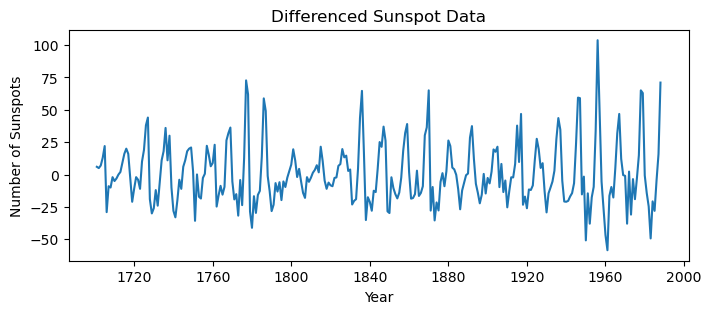

sunspot_diff ADF Statistic: -14.076125927559799
sunspot_diff p-value: 2.8827295545410874e-26


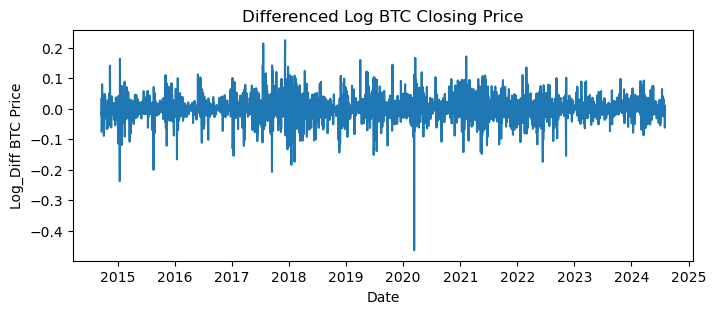

BTC Log Diff ADF Statistic: -18.253637926573347
BTC Log Diff p-value: 2.3397834562125365e-30


In [242]:
# Difference the sunspot data
sunspot_diff = sunspot_data['value'].diff().dropna()

# log transform the BTC closing price and difference
btc_log = np.log(btc_close)
btc_log_diff = btc_log.diff().dropna()

#  plot sunspot_diff and Perform ADF test 
plt.figure(figsize=(8, 3))
plt.plot(sunspot_diff)
plt.title('Differenced Sunspot Data')
plt.xlabel('Year')
plt.ylabel('Number of Sunspots')
plt.show()

result = adfuller(sunspot_diff)
print(f'sunspot_diff ADF Statistic: {result[0]}')
print(f'sunspot_diff p-value: {result[1]}')

#  plot btc_log_diff and Perform ADF test
plt.figure(figsize=(8, 3))
plt.plot(btc_log_diff)
plt.title('Differenced Log BTC Closing Price')
plt.xlabel('Date')
plt.ylabel('Log_Diff BTC Price')
plt.show()

result = adfuller(btc_log_diff)
print(f'BTC Log Diff ADF Statistic: {result[0]}')
print(f'BTC Log Diff p-value: {result[1]}')
    

## Autocorrelation (ACF) and Partial Autocorrelation (PACF) Analysis
If the PACF plot shows a sharp cut-off, consider an AR model.
If the ACF plot shows a sharp cut-off, consider an MA model.
Model Order: The cut-off point in the ACF or PACF plots indicates the order (p for AR, q for MA).

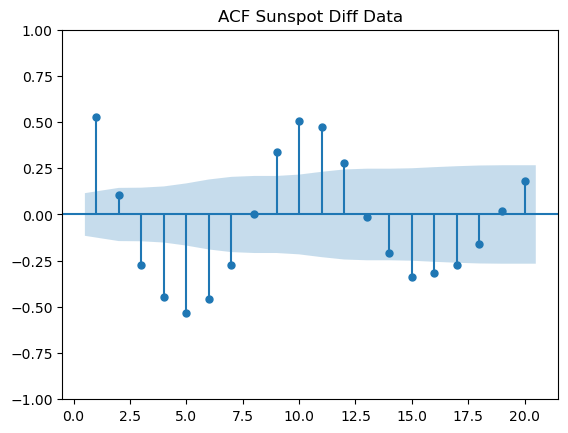

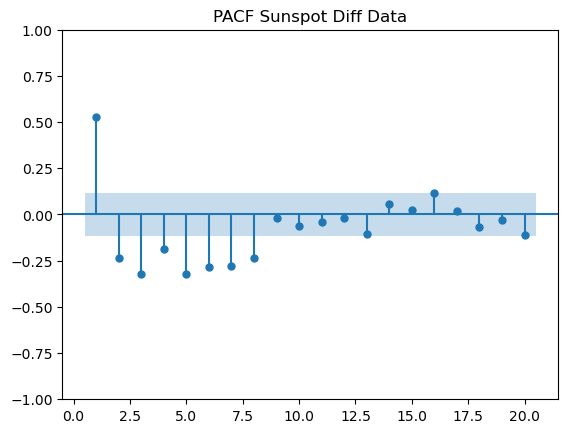

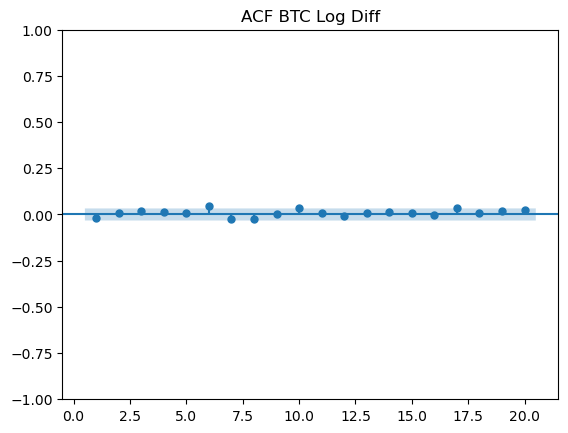

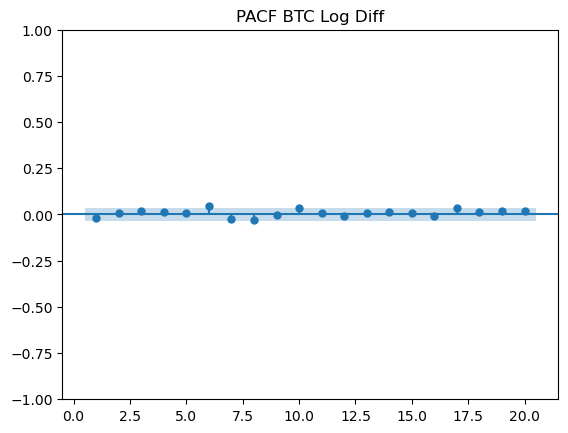

In [244]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF on the differenced sunspot data
plot_acf(sunspot_diff, title='ACF Sunspot Diff Data',lags=20, zero=False)
plot_pacf(sunspot_diff, title='PACF Sunspot Diff Data',lags=20, zero=False)
plt.show()

# Plot ACF and PACF on the differenced log BTC closing price
plot_acf(btc_log_diff, title='ACF BTC Log Diff',lags=20, zero=False)
plot_pacf(btc_log_diff, title='PACF BTC Log Diff',lags=20, zero=False)
plt.show()

- Sunspot shows ACF of a cyclic patern and PACF significant spikes up to 8 lags
- BTC Log Diff has no apperant Autocorrelation therfore is not suitable for AR modeling

## Fit the Model and Evaluate results
 Use the AutoReg function for AR models or ARIMA with p=0 for MA models


In [245]:
print(sunspot_diff.shape)
# Split data to train and test,use last 30 values as test set
train_sunspot, test_sunspot = sunspot_diff[:-30], sunspot_diff[-30:]
print('train shape:', train_sunspot.shape)
print('test shape:', test_sunspot.shape)

(288,)
train shape: (258,)
test shape: (30,)


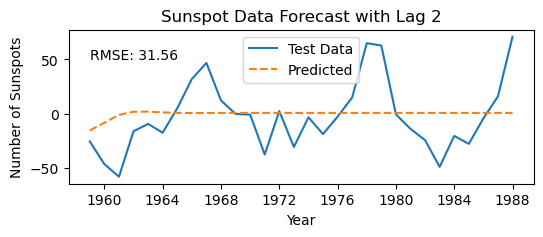

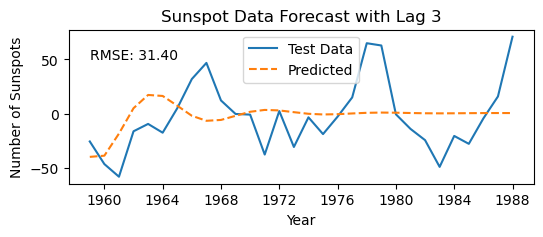

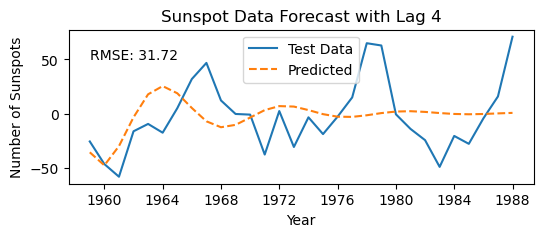

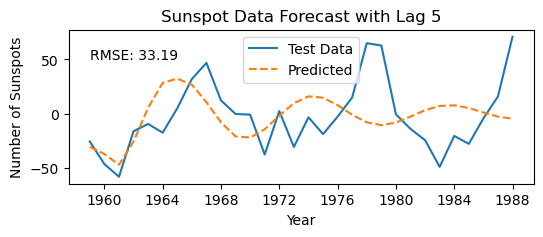

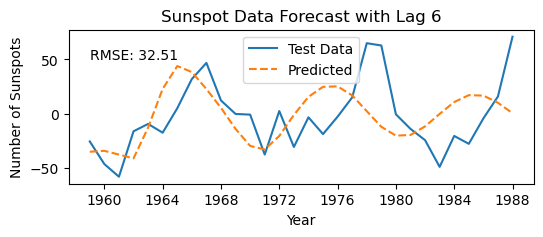

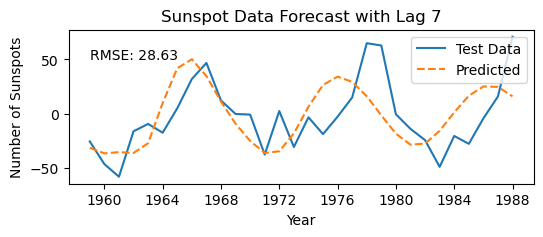

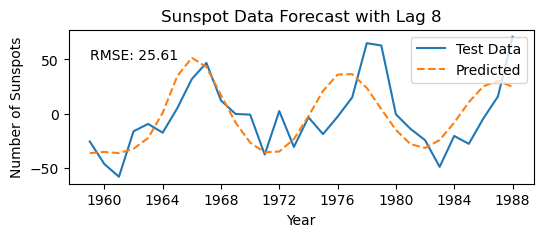

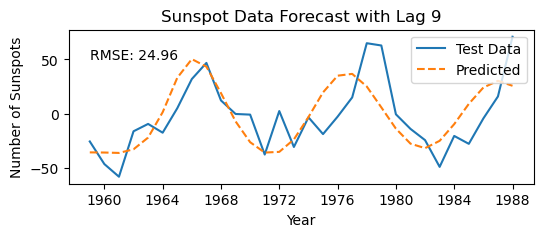

In [255]:
# creat loop to find the best lag and plot the test data and the predicted data
for i in range(2, 10):
    model = AutoReg(train_sunspot, lags=i)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train_sunspot), end=len(train_sunspot)+len(test_sunspot)-1)
    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_sunspot, predictions))

    plt.figure(figsize=(6, 2))
    plt.plot(test_sunspot.index, test_sunspot, label='Test Data')  
    plt.plot(test_sunspot.index, predictions, label='Predicted', linestyle='--')
    plt.title(f'Sunspot Data Forecast with Lag {i}')
    plt.xlabel('Year')
    plt.ylabel('Number of Sunspots')
    plt.text(test_sunspot.index[0], 50, f'RMSE: {rmse:.2f}')
    plt.legend()
    plt.show()

## Evaluate the Model

                            AutoReg Model Results                             
Dep. Variable:                  value   No. Observations:                  258
Model:                     AutoReg(9)   Log Likelihood               -1022.773
Method:               Conditional MLE   S.D. of innovations             14.711
Date:                Mon, 07 Oct 2024   AIC                           2067.545
Time:                        10:14:58   BIC                           2106.237
Sample:                    01-01-1710   HQIC                          2083.119
                         - 01-01-1958                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7465      0.935      0.798      0.425      -1.086       2.579
value.L1       0.2295      0.063      3.618      0.000       0.105       0.354
value.L2      -0.2261      0.064     -3.536      0.0

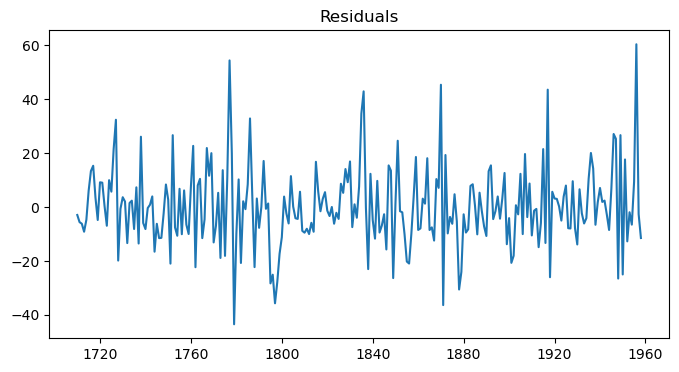

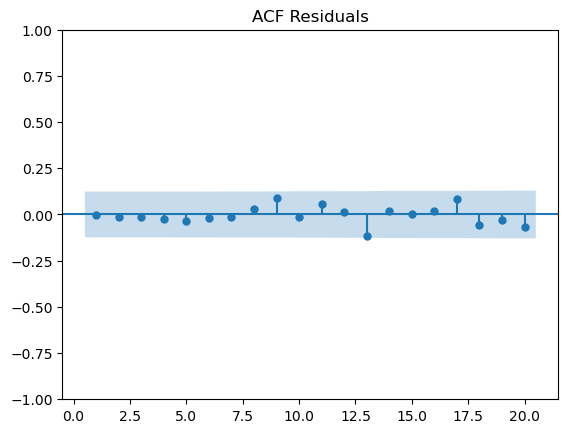

In [260]:
#plot the model summary
print(model_fit.summary())

# Plot residuals
residuals = model_fit.resid
plt.figure(figsize=(8, 4))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Plot residuals ACF 
plot_acf(residuals, title='ACF Residuals',lags=20, zero=False)
plt.show()

# ARIMA model implementation
Example on the Air Passenger Time sereis

### Supporting function

In [102]:
def test_stationarity(timeseries,window=12):
    #Determing rolling statistics
    MA = timeseries.rolling(window=window).mean()
    MSTD = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    plt.figure(figsize=(8,3))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# a function to plot 3 figures: the original data, ACF and PACF on a subplot
def plot_data_acf_pacf(data, lags=40):
    fig, ax = plt.subplots(3, 1, figsize=(8, 8))
    ax[0].plot(data)
    ax[0].set_title('Original Data')
    plot_acf(data, lags=lags, ax=ax[1], zero=False)
    plot_pacf(data, lags=lags, ax=ax[2], zero=False) 
    plt.tight_layout()   
    plt.show()

# function to plot the forecast vs actuals (test) values and calculate the RMSE
def plot_forecast_vs_actuals(train, test, forecast): 
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f'ARIMA RMSE: {rmse:.2f}')

    # Plot the results
    plt.figure(figsize=(8, 4))
    plt.plot(train.index, train, label='Train Data')
    plt.plot(test.index, test, label='Test Data', color='gray')
    plt.plot(test.index, forecast, label='ARIMA Forecast', linestyle='--')
    plt.title('Forecast vs Actuals')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

## Visualize the data & Enforce Stetionarity

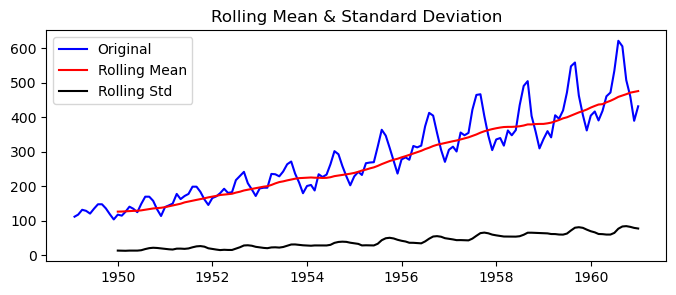

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [103]:
test_stationarity(airp_df)

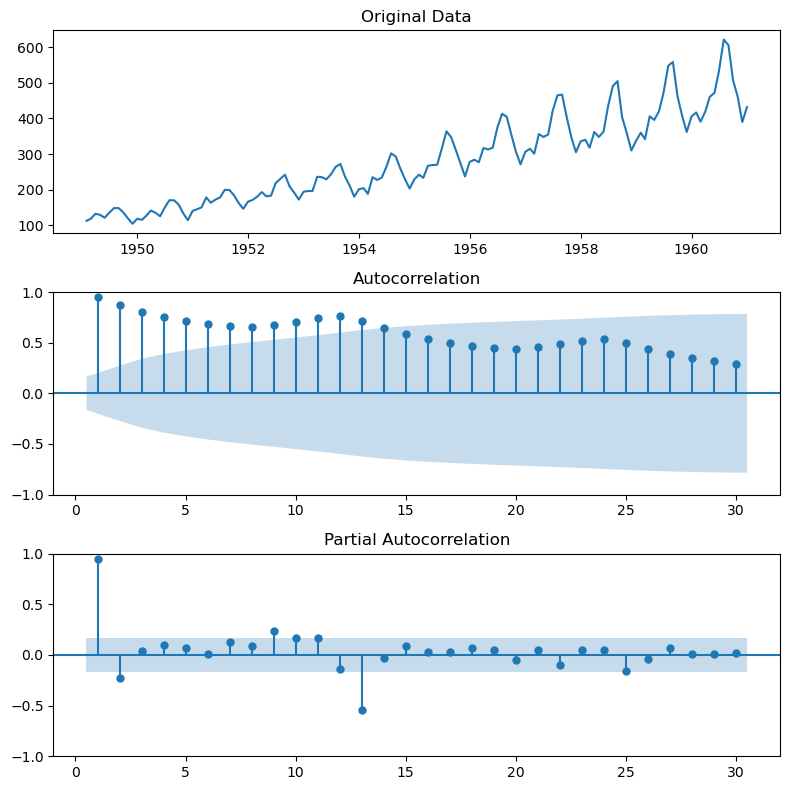

In [88]:
plot_data_acf_pacf(airp_df, lags=30)

- Data has clear trend and seasonality, clearly not stationary.
- **ACF** graph presents a positive decaying correlation indicating trend and seasonality
- **PACF** The 1st and second lags are significant (out of the confidence interval). Cut off after first lag. the spike in 12th lag indicated the seasonal yearly pattern

 Use differencing to enforce stationarity

### First order differencing

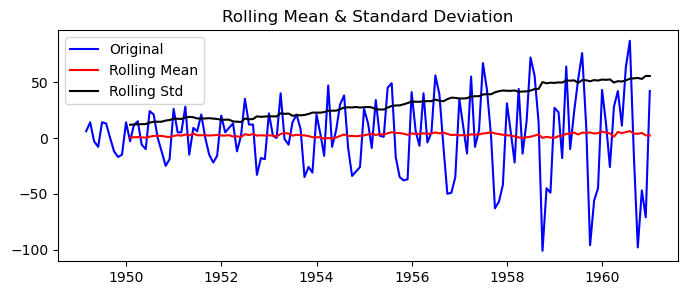

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [104]:
data_diff = airp_df.diff().dropna()
test_stationarity(data_diff)

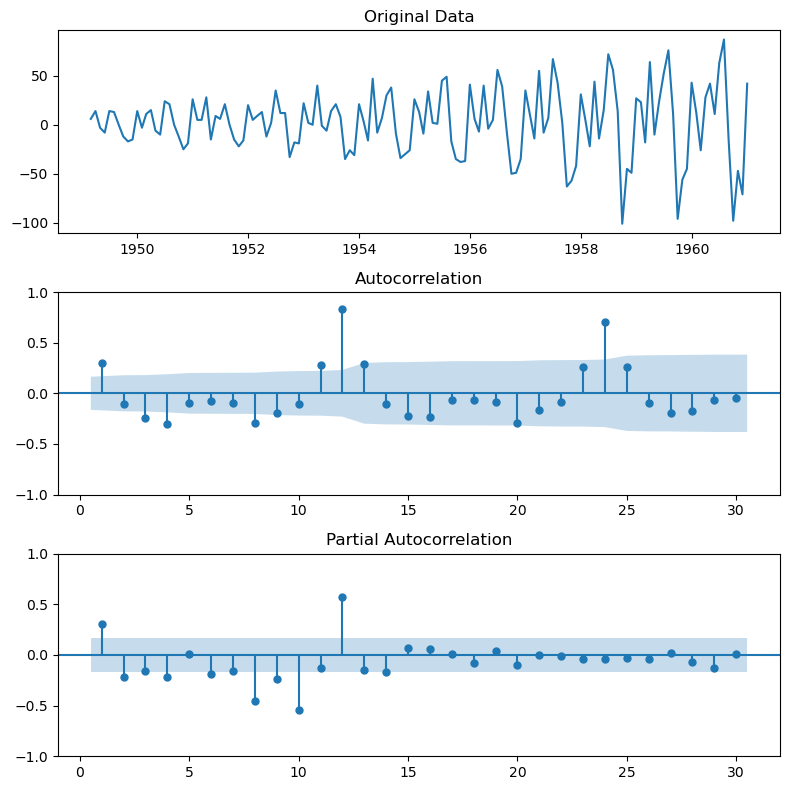

In [183]:
plot_data_acf_pacf(data_diff, lags=30)

- first order differencing removes trend but does not handle seasonality and increasing Variabilty
- p-value > 0.05, data is not stationary

### Seasonal differencing 

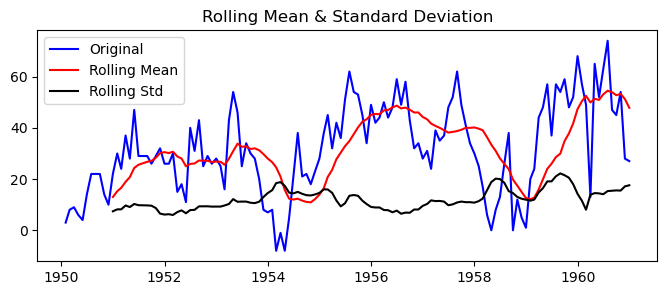

Results of Dickey-Fuller Test:
Test Statistic                  -3.383021
p-value                          0.011551
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [108]:
# Seasonal differencing + first order differencing
data_deseason = airp_df.diff(12).dropna() # Seasonal differencing with period 12 months
test_stationarity(data_deseason)

- Trend is reduced, yearly seasonality eliminated, but MA incated some trend leftover
- p-value < 0.05 indicatd data is stationary (according to ADF test)

### Seasonal differencing + first order differencing

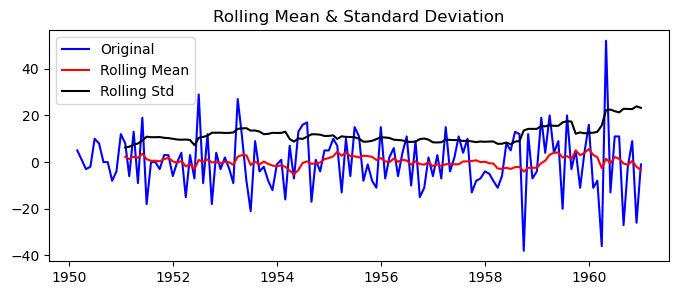

Results of Dickey-Fuller Test:
Test Statistic                -1.559562e+01
p-value                        1.856512e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


In [107]:
# Seasonal differencing + first order differencing
data_deseason_diff = airp_df.diff(12).diff().dropna()
test_stationarity(data_deseason_diff)

- Trand and seasonality are eliminated, variabilityis still shows slight increas
- p-value << 0.05 indicatd data is stationary


## Modeling ARIMA

## De-Seasonalize 

#### Select the orders of p & q, by ploting ACF PACF

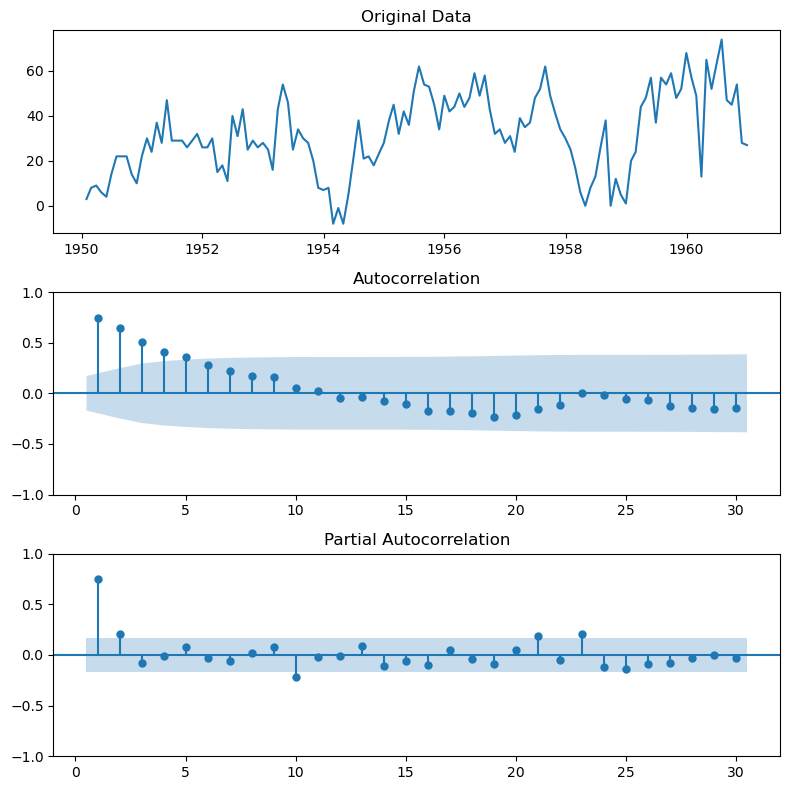

In [192]:
plot_data_acf_pacf(data_deseason, lags=30)

- The ACF is gradualy decreasing- indicating a MA processes with 4 significant lags
- The PACF has sharp cut of after lag 1- indicating possible AR process with 1 significant lag
- From the above plots, the initial orders of **ARIMA** model is selected 
    - **p** : 1 initial significant lags of the PACF plot
    - **d** : 0 Data is already stationary
    - **q** : 4 initial significant lags of the ACF plot

#### Split data to train and test

In [233]:
# split the data into train and test, with last 30 months as test set
train, test , test_size = split_data(data_deseason, test_prop=0.2)

train shape: (106, 1)
test shape: (26, 1)


#### Fit the model and forcast

In [234]:
model = ARIMA(train,order = (2,0,4))
model_fit = model.fit()
print(model_fit.summary())

#print the AIC value
print(f'\nAIC: {model_fit.aic}')

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  106
Model:                 ARIMA(2, 0, 4)   Log Likelihood                -389.657
Date:                Mon, 07 Oct 2024   AIC                            795.314
Time:                        09:56:34   BIC                            816.621
Sample:                    01-31-1950   HQIC                           803.950
                         - 10-31-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7392      5.293      4.863      0.000      15.365      36.114
ar.L1          0.0107      0.167      0.064      0.949      -0.316       0.337
ar.L2          0.7642      0.125      6.116      0.0

ARIMA RMSE: 27.73


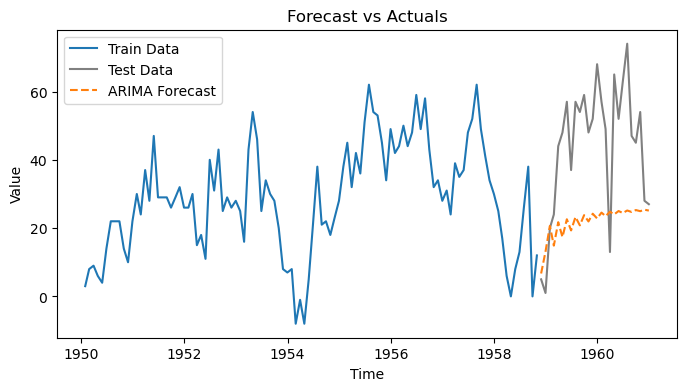

In [235]:
# Forecast the test data
forecast = model_fit.forecast(steps=test_size)
plot_forecast_vs_actuals(train, test, forecast)


ARIMA RMSE: 25.40


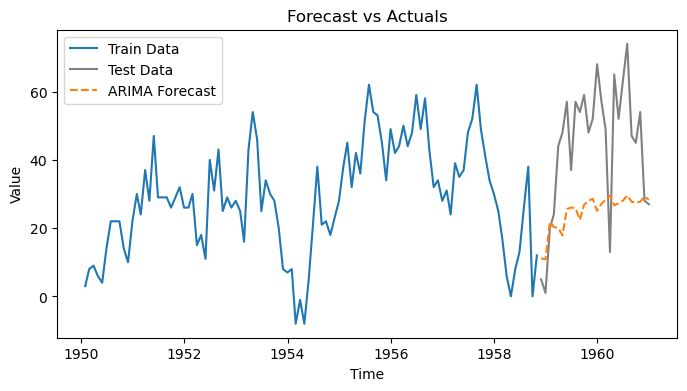

In [236]:
model = ARIMA(train,order = (5,0,5))
model_fit = model.fit()
forecast = model_fit.forecast(steps=test_size)
plot_forecast_vs_actuals(train, test, forecast)

#### Make in-sample prediction 

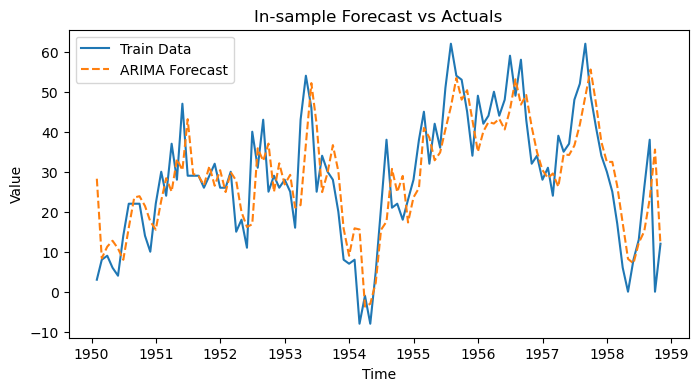

In [237]:
# Make in-sample prediction 
forecast_insample = model_fit.predict(start=0, end=len(train)-1)
# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(train.index, train, label='Train Data')
plt.plot(train.index, forecast_insample, label='ARIMA Forecast', linestyle='--')
plt.title('In-sample Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


#### Evaluate Residuals

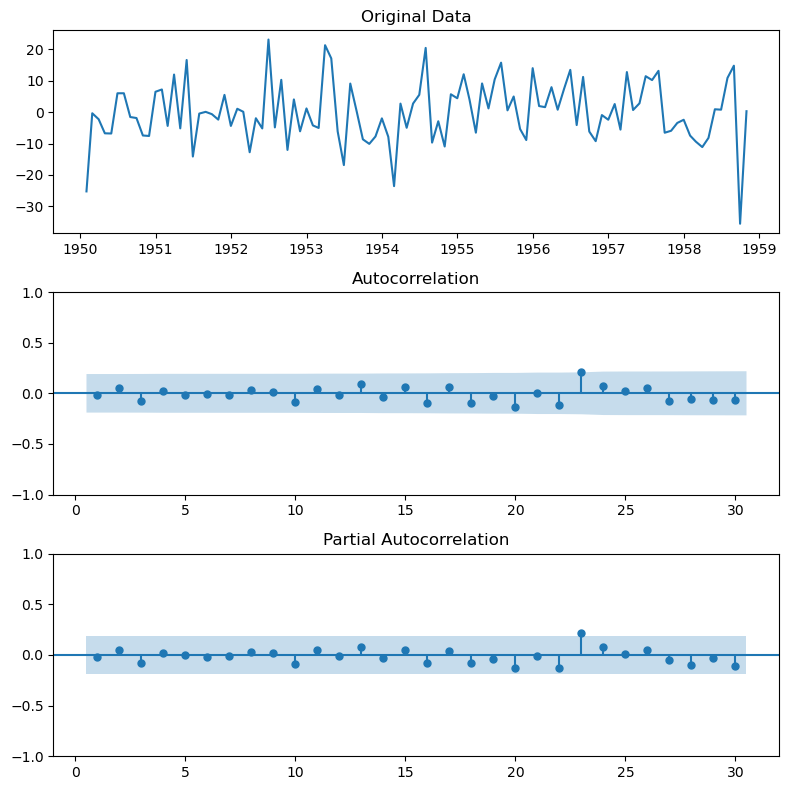

In [239]:
# Evaluate the residuals
residuals = model_fit.resid
plot_data_acf_pacf(residuals, lags=30)

#### Reconstruct the forecasted data to the original scale 

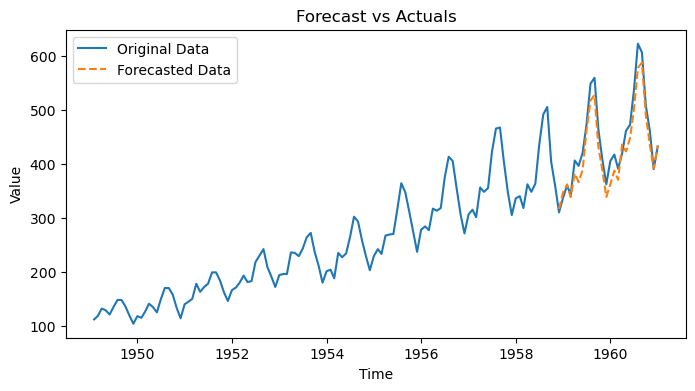

In [240]:
# reconstruct the forecasted data to the original scale 
forecast_reconstructed = forecast.copy()
# creat df of forecasted data with the test index
forecast_reconstructed = pd.DataFrame(forecast_reconstructed, index=test.index)

# replace the values in the original data with the forecasted values
airp_df_reconstructed = airp_df.copy()
airp_df_reconstructed.loc[test.index] = forecast_reconstructed.values

# to each forecasted value add the value of 12 months ago
airp_df_reconstructed.loc[test.index] = airp_df_reconstructed.loc[test.index] + airp_df.loc[test.index - pd.DateOffset(months=12)].values

# cut the test index from the airp_df_reconstructed
forecast_reconstructed = airp_df_reconstructed.loc[test.index]

# plot the original data and the forecasted data
plt.figure(figsize=(8, 4))
plt.plot(airp_df, label='Original Data')
plt.plot(forecast_reconstructed, label='Forecasted Data', linestyle='--')
plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


## De-Seasonalize + Differenced Data

#### Select the orders of p & q, by ploting ACF PACF

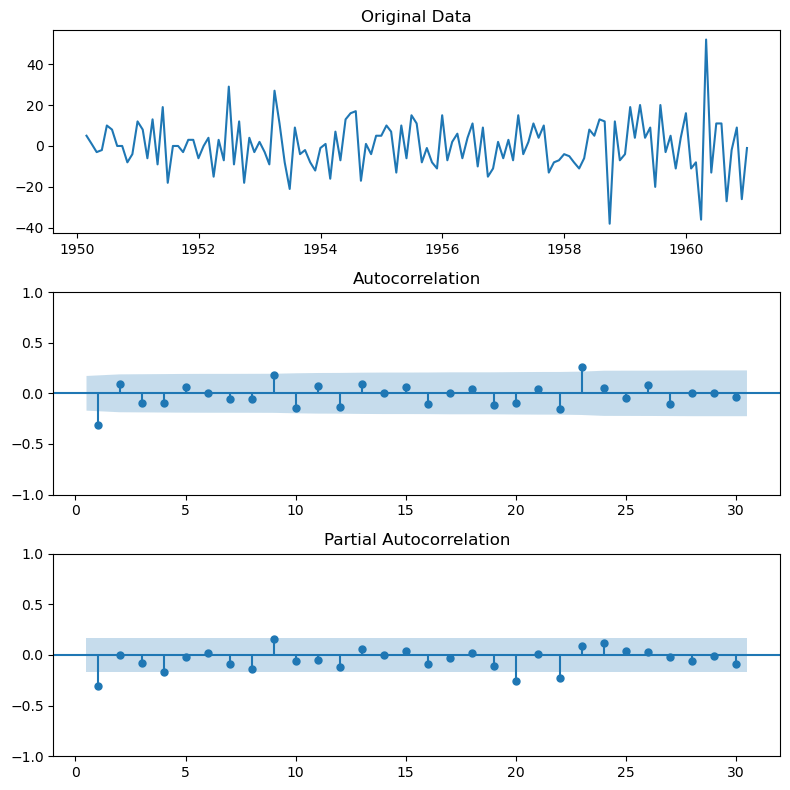

In [163]:
plot_data_acf_pacf(data_deseason_diff, lags=30)

- The data passed for model fitting is the **Deseasonal Deifferenced Data** 
- From the above plots, the initial orders of **ARIMA** model is selected 
    - **p** : 1 initial significant lags of the PACF plot
    - **d** : 0 Data is already stationary
    - **q** : 1 initial significant lags of the ACF plot

#### Split data to train and test

In [164]:
# split the data into train and test, with last 30 months as test set
train, test , test_size = split_data(data_deseason_diff, test_prop=0.1)

train shape: (118, 1)
test shape: (13, 1)


#### Fit the model and forcast

In [165]:
model = ARIMA(train,order = (1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  118
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -442.596
Date:                Sun, 06 Oct 2024   AIC                            893.191
Time:                        18:03:44   BIC                            904.274
Sample:                    02-28-1950   HQIC                           897.691
                         - 11-30-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4007      0.823      0.487      0.626      -1.212       2.013
ar.L1         -0.5907      0.282     -2.095      0.036      -1.143      -0.038
ma.L1          0.3659      0.310      1.181      0.2

ARIMA RMSE: 22.38


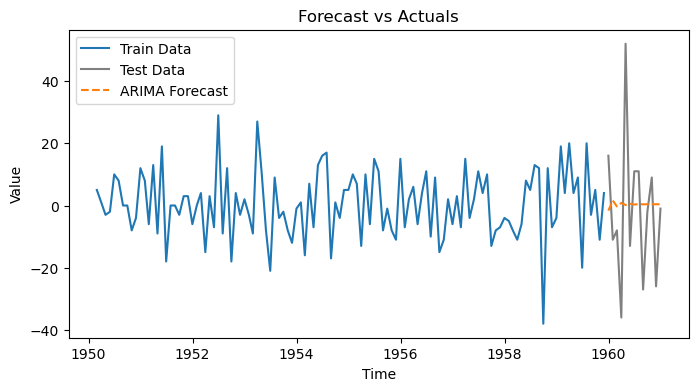

In [167]:
# Forecast the test data
forecast = model_fit.forecast(steps=test_size)
plot_forecast_vs_actuals(train, test, forecast)


ARIMA RMSE: 19.21


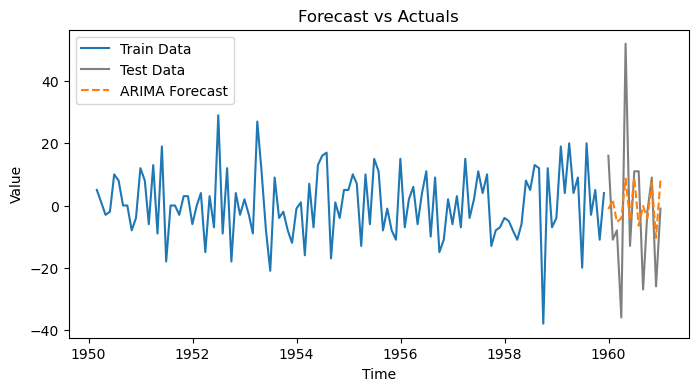

In [168]:
model = ARIMA(train,order = (10,0,10))
model_fit = model.fit()
forecast = model_fit.forecast(steps=test_size)
plot_forecast_vs_actuals(train, test, forecast)

## Auto ARIMA- find optimal parameters using built in function

In [147]:
from pmdarima import auto_arima

#### De-Seasonalize data

train shape: (119, 1)
test shape: (13, 1)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=903.199, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1179.879, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=905.378, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1078.397, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=903.031, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1015.519, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=902.013, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=901.394, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=900.945, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=901.727, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=903.300, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=895.591, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=896.732, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=894.208, Time=0.02 sec
 A

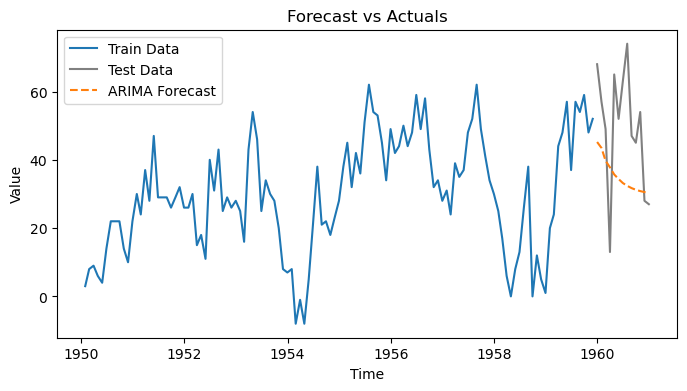

In [160]:
# train test split
train, test, test_size = split_data(data_deseason, test_prop=0.1)

model = auto_arima(train, 
                   seasonal=False, 
                   stepwise=True,
                   suppress_warnings=True,
                   trace=True) # set trace to True to print the steps


# print the parameters of the best model params and fit the model with the best params
print('best params:')   
print(model.get_params())

model.fit(train)

# Forecast the test data
forecast = model.predict(n_periods=test_size)
plot_forecast_vs_actuals(train, test, forecast)




#### Original data with seasonality

train shape: (116, 1)
test shape: (28, 1)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=766.298, Time=0.51 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=765.723, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=764.756, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=765.328, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=764.138, Time=0.01 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=764.944, Time=0.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=766.619, Time=0.14 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=765.206, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=762.550, Time=0.03 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=765.329, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=765.510, Time=0.17 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=767.126, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=764.631, Time=0.01 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=766.465, Time=

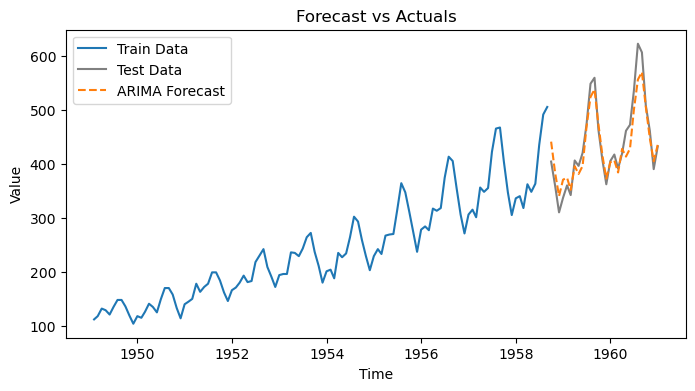

In [179]:
# train test split
train, test, test_size = split_data(airp_df, test_prop=0.2)

model = auto_arima(train, 
                   seasonal=True, # set seasonal to True
                   m=12, # set the seasonal period to 12 months
                   stepwise=True,
                   suppress_warnings=True,
                   trace=True) # set trace to True to print the steps


# print the parameters of the best model params and fit the model with the best params
print('best params:')   
print(model.get_params())

model.fit(train)

# Forecast the test data
forecast = model.predict(n_periods=test_size)
plot_forecast_vs_actuals(train, test, forecast)

#### Make in-sample prediction and evaluate residuals

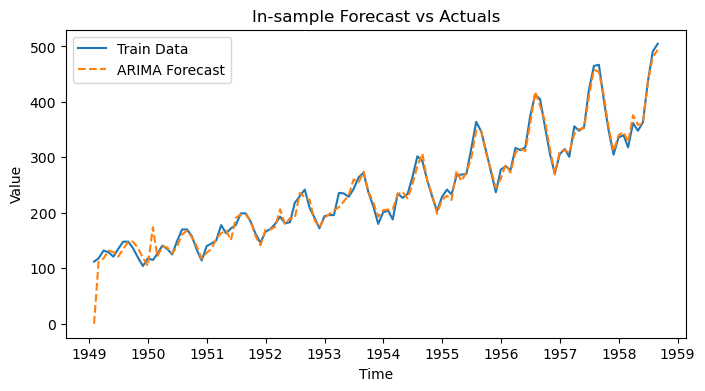

In [181]:
# Make in-sample prediction 
forecast_insample = model.predict_in_sample()
# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(train.index, train, label='Train Data')
plt.plot(train.index, forecast_insample, label='ARIMA Forecast', linestyle='--')
plt.title('In-sample Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


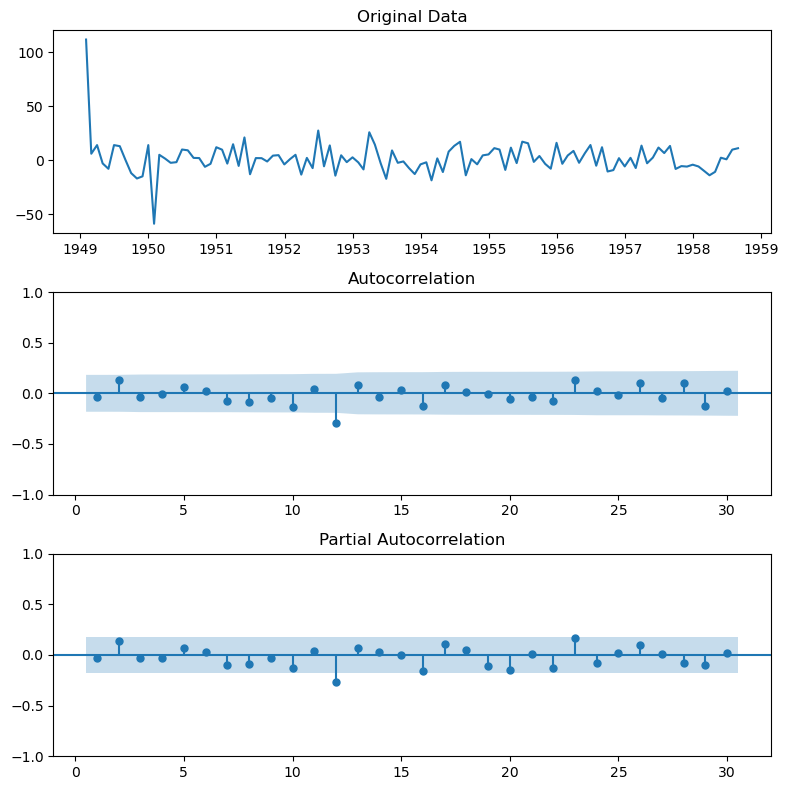

In [182]:
# Evaluate the residuals
residuals = model.resid()
plot_data_acf_pacf(residuals, lags=30)